In [64]:
# merge_all.csv 파일을 사용하여 "가격 (원)" 컬럼의 값을 예측하는 모델을 만든다

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
import keras
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import LeakyReLU
from keras.layers import PReLU
from keras.layers import ELU
from keras.layers import ThresholdedReLU
from keras.layers import Softmax
from keras.layers import ReLU
from keras.layers import GaussianNoise
from keras.layers import GaussianDropout
from keras.layers import AlphaDropout
from keras.layers import ActivityRegularization
from keras.layers import Masking
from keras.layers import SpatialDropout1D
from sklearn.metrics import r2_score





In [65]:
# 데이터 불러오기
df = pd.read_csv('data/merge_all/merge_all.csv')

# 데이터 전처리
# "거래년월일" 컬럼을 인덱스로 설정
df = df.set_index('거래년월일')
# "평균" 컬럼을 배추가격으로 설정
df = df.rename(columns={'평균':'배추가격'})
df.head()

,자동차용 경유 가격 (원),전월비(%),배추가격,거래량
거래년월일,,,,
2000-01-01,583.35,4.0,5600.0,102285.0
2000-01-02,583.35,4.0,5600.0,102285.0
2000-01-03,583.35,4.0,5600.0,102285.0
2000-01-04,583.35,4.0,5600.0,715338.0
2000-01-05,583.35,4.0,5620.0,340568.0


In [66]:
# "자동차용 경유 가격 (원)","전월비(%)","거래량" 컬럼을 사용하여 "배추가격" 컬럼의 값을 예측한다


# LSTM을 사용하기 위해 데이터를 정규화한다
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)
df_scaled

array([[0.02232381, 0.54045307, 0.10679612, 0.02824318],
       [0.02232381, 0.54045307, 0.10679612, 0.02824318],
       [0.02232381, 0.54045307, 0.10679612, 0.02824318],
       ...,
       [0.8637196 , 0.15210356, 0.10857143, 0.05564866],
       [0.8637196 , 0.15210356, 0.1065742 , 0.02129324],
       [0.8637196 , 0.15210356, 0.09686546, 0.0330776 ]])

In [68]:

# 데이터를 학습 데이터와 테스트 데이터로 나눈다
train_size = int(len(df_scaled) * 0.8)
test_size = len(df_scaled) - train_size
train, test = df_scaled[0:train_size,:], df_scaled[train_size:len(df_scaled),:]

# LSTM을 사용하여 닫힌 예측 모델을 만든다
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# look_back = 1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainY.shape

(6694,)

In [49]:
# 데이터를 (샘플 수, 타임 스텝, 특성 수) 형태로 변환한다
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[2]))

# 모델을 생성한다
model = Sequential()
model.add(LSTM(32, input_shape=(1, look_back*4)))
model.add(Dense(4))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 32)                4736      
                                                                 
 dense_4 (Dense)             (None, 4)                 132       
                                                                 
Total params: 4,868
Trainable params: 4,868
Non-trainable params: 0
_________________________________________________________________


In [50]:
#  EarlyStopping을 사용하여 과적합을 방지한다
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# 모델을 학습한다
history = model.fit(trainX, trainY, epochs=100, batch_size=32, verbose=1, validation_data=(testX, testY), callbacks=[early_stop])

Epoch 1/100


2022-12-23 10:55:21.911965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-23 10:55:22.033109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  5/210 [..............................] - ETA: 2s - loss: 0.2832  

2022-12-23 10:55:22.408066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - ETA: 0s - loss: 0.0786

2022-12-23 10:55:24.555010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-23 10:55:24.597033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - 4s 11ms/step - loss: 0.0786 - val_loss: 0.0122
Epoch 2/100
210/210 [==============================] - 2s 9ms/step - loss: 0.0084 - val_loss: 5.1100e-04
Epoch 3/100
210/210 [==============================] - 2s 10ms/step - loss: 3.6200e-04 - val_loss: 3.9580e-04
Epoch 4/100
210/210 [==============================] - 2s 9ms/step - loss: 1.9765e-04 - val_loss: 3.0965e-04
Epoch 5/100
210/210 [==============================] - 2s 9ms/step - loss: 1.6593e-04 - val_loss: 2.7030e-04
Epoch 6/100
210/210 [==============================] - 2s 9ms/step - loss: 1.4774e-04 - val_loss: 2.3398e-04
Epoch 7/100
210/210 [==============================] - 2s 9ms/step - loss: 1.3295e-04 - val_loss: 2.1361e-04
Epoch 8/100
210/210 [==============================] - 2s 9ms/step - loss: 1.1876e-04 - val_loss: 1.8865e-04
Epoch 9/100
210/210 [==============================] - 2s 9ms/step - loss: 1.0509e-04 - val_loss: 1.6617e-04
Epoch 10/100
210/210 [===================

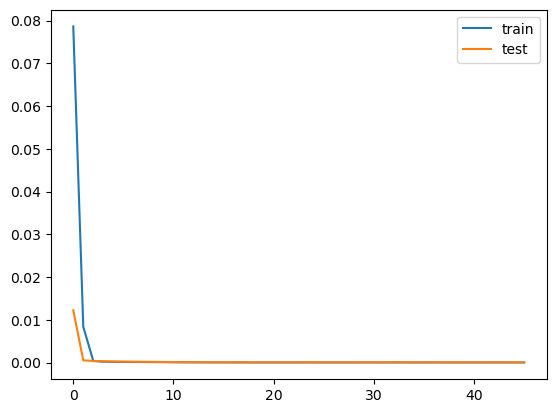

In [51]:
# 학습 결과를 그래프로 출력한다
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
# 실제 데이터 그래프로 출력한다
plt.legend()
plt.show()


In [52]:
#  모델을 평가한다
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00 MSE (0.00 RMSE)
Test Score: 0.00 MSE (0.01 RMSE)


In [72]:
# 모델을 사용하여 예측한다
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict

53/53 [==============================] - 0s 3ms/step


array([[0.02438572, 0.024124  , 0.02415452, 0.02384646],
       [0.02438572, 0.024124  , 0.02415452, 0.02384646],
       [0.02438572, 0.024124  , 0.02415452, 0.02384646],
       ...,
       [0.5214411 , 0.5213403 , 0.5212622 , 0.5215857 ],
       [0.52143615, 0.5213382 , 0.5212584 , 0.5215823 ],
       [0.52143615, 0.5213382 , 0.5212584 , 0.5215823 ]], dtype=float32)

 35/210 [====>.........................] - ETA: 0s

2022-12-23 10:56:53.259629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-23 10:56:53.298043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - 0s 3ms/step


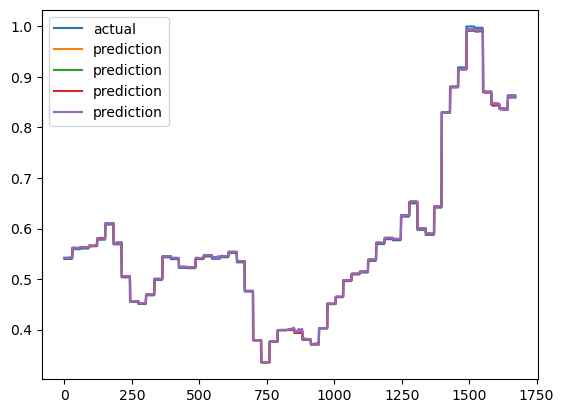

In [53]:

# 예측 결과를 그래프로 출력한다
plt.plot(testY, label='actual')
plt.plot(testPredict, label='prediction')
plt.legend()
plt.show()


In [63]:
# trainPredict.shape
trainY

array([0.02232381, 0.02232381, 0.02232381, ..., 0.51951872, 0.51951872,
       0.51951872])

In [71]:
#  예측 결과를 역정규화한다
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)
trainPredict




array([[ 5.8652551e+02, -1.1954568e+01,  2.6207703e+03,  8.6371273e+04],
       [ 5.8652551e+02, -1.1954568e+01,  2.6207703e+03,  8.6371273e+04],
       [ 5.8652551e+02, -1.1954568e+01,  2.6207703e+03,  8.6371273e+04],
       ...,
       [ 1.3520206e+03,  3.4094155e+00,  2.0541504e+04,  1.8879175e+06],
       [ 1.3520129e+03,  3.4093511e+00,  2.0541365e+04,  1.8879052e+06],
       [ 1.3520129e+03,  3.4093511e+00,  2.0541365e+04,  1.8879052e+06]],
      dtype=float32)